# Advanced Lane Finding

In [1]:
import cv2
import numpy as np
import os
import math

from moviepy.editor import VideoFileClip

%matplotlib inline
import matplotlib.pyplot as plt

## Load Input Images and Videos

In [2]:
INPUT_IMAGE_DIR = "test_images"
OUTPUT_IMAGE_DIR = "output_images"
input_images = []
for image_name in os.listdir(INPUT_IMAGE_DIR):
    image_path = os.path.join(INPUT_IMAGE_DIR, image_name)
    img = plt.imread(image_path)
    input_images.append(img)

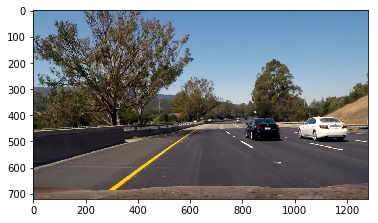

In [3]:
image_id = 0
plt.imshow(input_images[image_id])
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "input_image_copy.png"), input_images[image_id])

## Camera Calibration and Distortion Correction

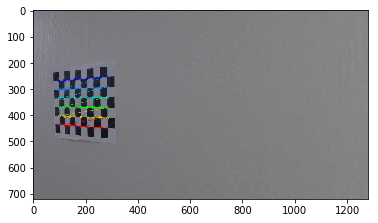

In [4]:
# Create list of object points and image points. 
CAMERA_CALIBRATION_DIR = "camera_cal"
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints = []
imgpoints = []
for image_name in os.listdir(CAMERA_CALIBRATION_DIR):
    image_path = os.path.join(CAMERA_CALIBRATION_DIR, image_name)
    img = plt.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

# Display the last image, with corners marked. 
plt.imshow(img)
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "checkerboard_corners_detected.png"), img)

# Calculate the distortion parameters. 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
def undistort(input_image):
    """Return the un-distorted (calibrated) image. """
    dst = cv2.undistort(input_image, mtx, dist, None, mtx)
    return dst

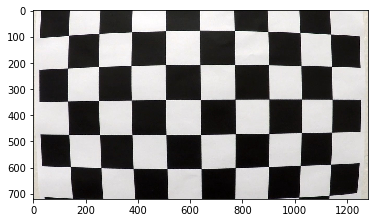

In [6]:
# Load one of the heavily-distorted images.
image_path = os.path.join(CAMERA_CALIBRATION_DIR, "calibration1.jpg")
img = plt.imread(image_path)
plt.imshow(img)
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "checkerboard_heavily_distorted.png"), img)

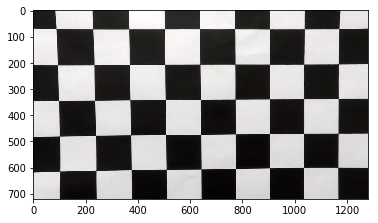

In [7]:
# Un-distort the image
dst = undistort(img)
plt.imshow(dst)
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "checkerboard_distortion_corrected.png"), dst)

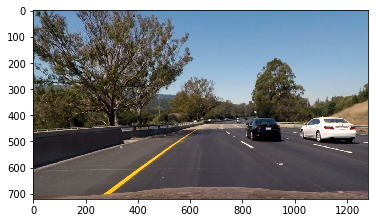

In [8]:
undistorted_images = [undistort(img) for img in input_images]
plt.imshow(undistorted_images[image_id])
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "distortion_corrected.png"), undistorted_images[image_id])

## Perspective Transform - Birds Eye View

In [9]:
# Points located on undistorted_images[1]. Based on example image from lesson 15.32. 
src = np.float32([[252, 687], [587, 456], [694, 456], [1053, 687]])
dst = np.float32([[320, 720], [320, 0], [960, 0], [960, 720]])
img_shape = undistorted_images[1].shape
img_size = img_shape[:2][::-1]

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [10]:
def transform_birds_eye_view(img):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [11]:
def inverse_transform_birds_eye_view(img):
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

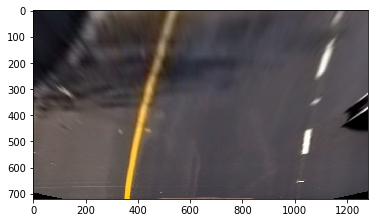

In [12]:
birds_eye_view_images = [transform_birds_eye_view(img) for img in undistorted_images]
plt.imshow(birds_eye_view_images[image_id])
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "birds_eye_view.png"), birds_eye_view_images[image_id])

## Color Transform, Gradient, Threshold (Binary Image)

In [13]:
def color_transform(img):
    """Average the red and green channels, ignoring blue. Return a grayscale image."""
    return np.mean(img[:,:,:2], axis=2)

In [14]:
def adjust_darkness(img):
    """Re-scale the brightness histogram linearly so that the average brightness becomes black."""
    img_mean = np.mean(img)
    img = np.maximum(0.0, img-img_mean) / (255.0-img_mean) * 255.0
    img = img.astype(np.uint8)
    return img

In [15]:
def adjust_gamma(img, gamma=2.0):
    img = np.float32(img/255.0)
    img = img ** gamma
    img_max = np.max(img)
    img = np.uint8(img/img_max*255.0)
    return img

Transformed to Grayscale


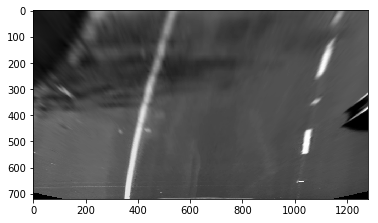

Darkness Adjusted


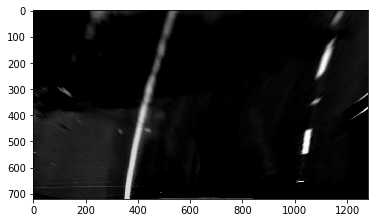

Gamma Adjusted


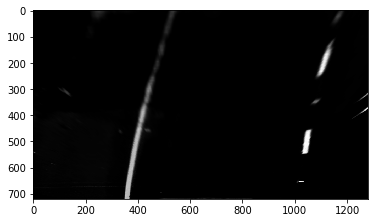

In [16]:
print("Transformed to Grayscale")
color_transformed_images = [color_transform(img) for img in birds_eye_view_images]
plt.imshow(color_transformed_images[image_id], cmap='gray')
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "grayscale.png"), color_transformed_images[image_id], cmap='gray')
print("Darkness Adjusted")
darkness_adjusted_images = [adjust_darkness(img) for img in color_transformed_images]
plt.imshow(darkness_adjusted_images[image_id], cmap='gray')
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "darkness_adjusted.png"), darkness_adjusted_images[image_id], cmap='gray')
print("Gamma Adjusted")
gamma_adjusted_images = [adjust_gamma(img) for img in darkness_adjusted_images]
plt.imshow(gamma_adjusted_images[image_id], cmap='gray')
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "gamma_adjusted.png"), gamma_adjusted_images[image_id], cmap='gray')

In [17]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        return None
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.logical_and(scaled_sobel>thresh[0], scaled_sobel<thresh[1])
    return grad_binary

In [18]:
def grad_threshold(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=29, thresh=(10, 255))
    return gradx

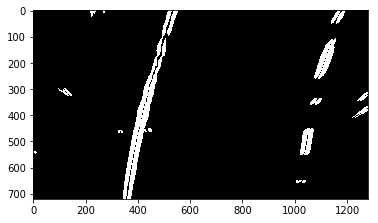

In [19]:
binary_images = [grad_threshold(img).astype(np.float32) for img in gamma_adjusted_images]
plt.imshow(binary_images[image_id], cmap='gray')
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "grad_threshold.png"), binary_images[image_id], cmap='gray')

## Detect Lane Pixels and Fit to Lane Boundary

Adapted from code found in lesson 15.34

In [20]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Where to evaluate curvature
y_eval = 600

In [21]:
def fit_polynomial(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Do not look all the way to the edge of the image
    ignore_margin = 200
    leftx_base = ignore_margin + np.argmax(histogram[ignore_margin:midpoint-ignore_margin])
    rightx_base = np.argmax(histogram[midpoint+ignore_margin:-ignore_margin]) + midpoint+ignore_margin

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    good_left_highest_window = 0
    good_right_highest_window = 0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            good_left_highest_window = window
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            good_right_highest_window = window

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    MINIMUM_GOOD_HEIGHT = 3
    left_fit = None
    left_fit_meters = None
    if good_left_highest_window >= MINIMUM_GOOD_HEIGHT:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = None
    right_fit_meters = None
    if good_right_highest_window >= MINIMUM_GOOD_HEIGHT:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, left_fit_meters, right_fit_meters

In [22]:
polynomials = [fit_polynomial(img) for img in binary_images]

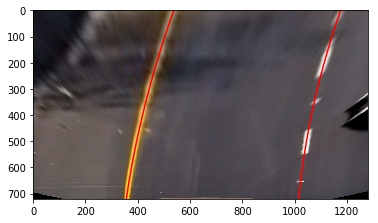

In [23]:
binary_warped = birds_eye_view_images[image_id]
[left_fit, right_fit, left_fit_meters, right_fit_meters] = polynomials[image_id]

plt.imshow(binary_warped, cmap='gray')

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
if left_fit is not None:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    plt.plot(left_fitx, ploty, color='red')
if right_fit is not None:
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.plot(right_fitx, ploty, color='red')

plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig(os.path.join(OUTPUT_IMAGE_DIR, "polynomial_fit.png"))
plt.show()

## Determine Curvature of the Lane and Position WRT Center

In [24]:
def curvature_from_polynomial(polynomial):
    """Find the curvature of 2nd order polynomial (3 coefficients) at y_eval. """
    curverad = ((1 + (2*polynomial[0]*y_eval*ym_per_pix + polynomial[1])**2)**1.5) / np.absolute(2*polynomial[0])
    return curverad

In [25]:
def position_wrt_center(left_polynomial, right_polynomial):
    """Find the position of the car WRT the center of the lane given 2 2nd order polynomials. """
    y_bottom = img_shape[0]*ym_per_pix
    left_bottom = left_polynomial[0]*y_bottom**2 + left_polynomial[1]*y_bottom + left_polynomial[2]
    right_bottom = right_polynomial[0]*y_bottom**2 + right_polynomial[1]*y_bottom + right_polynomial[2]
    lane_center = (left_bottom + right_bottom)/2.0
    position = xm_per_pix*img_shape[1]/2.0 - lane_center
    return position

In [26]:
curvature_radii = []
positions = []
for polynomial_set in polynomials:
    [left_fit, right_fit, left_fit_meters, right_fit_meters] = polynomial_set
    left_curverad = None
    if left_fit_meters is not None:
        left_curverad = curvature_from_polynomial(left_fit_meters)
    right_curverad = None
    if right_fit_meters is not None:
        right_curverad = curvature_from_polynomial(right_fit_meters)
    curvature_radii.append([left_curverad, right_curverad])
    position = None
    if (left_fit_meters is not None) and (right_fit_meters is not None):
        position = position_wrt_center(left_fit_meters, right_fit_meters)
    positions.append(position)
print("Curve Radius:", curvature_radii[image_id])
print("Position WRT Center:", positions[image_id])

Curve Radius: [1132.48681518177, 934.8040621952186]
Position WRT Center: -0.24385160235096448


## Warp the Detected Lane Boundaries back Onto Original Image

In [27]:
def overlay_detected_lane(img, left_polynomial, right_polynomial):
    """Shade in the area between two 2nd order polynomials. """
    birds_eye_view_lane = np.zeros(img_shape, np.uint8)
    if (left_polynomial is not None) and (right_polynomial is not None):
        for y in range(img_shape[0]):
            left_fitx = max(0, int(left_polynomial[0]*y**2 + left_polynomial[1]*y + left_polynomial[2]))
            right_fitx = min(img_shape[1], int(right_polynomial[0]*y**2 + right_polynomial[1]*y + right_polynomial[2]))
            birds_eye_view_lane[y, left_fitx:right_fitx+1, 1] = 127
    inv_transformed_lane = inverse_transform_birds_eye_view(birds_eye_view_lane)
    lane_overlay = cv2.add(img, inv_transformed_lane)
    return lane_overlay

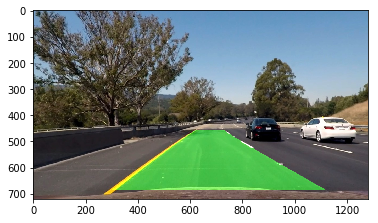

In [28]:
overlay_images = [overlay_detected_lane(
    undistorted_images[image_id], 
    polynomials[image_id][0], 
    polynomials[image_id][1]) for image_id in range(len(undistorted_images))]
plt.imshow(overlay_images[0])
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "lane_overlay.png"), overlay_images[image_id])

## Visual Display of Lane Boundaries and Numerical Estimates

In [29]:
def overlay_text(img, curve_radius, position):
    """Draw text (radius and position) on the image. """
    img = img.copy()
    if curve_radius < 2000.0:
        radius_str = r"Radius: {0:.0f}m".format(curve_radius)
    else:
        radius_str = r"Radius: >2000m"
    position_str = r"Position: {0:.2f}m".format(position)

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, radius_str, (20, 70), font, 2, (0, 255, 0), 2)
    cv2.putText(img, position_str, (20, 140), font, 2, (0, 255, 0), 2)
    return img

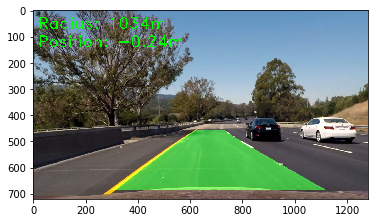

In [30]:
final_images = []
for i in range(len(overlay_images)):
    img = overlay_images[i]
    curve_radius = curvature_radii[i]
    position = positions[i]
    if position is not None:
        img = overlay_text(img, np.mean(curve_radius), position)
    final_images.append(img)

plt.imshow(final_images[image_id])
plt.show()
plt.imsave(os.path.join(OUTPUT_IMAGE_DIR, "final_image.png"), final_images[image_id])

## Full Pipeline and Video Processing

In [31]:
def full_pipeline(img):
    undistorted_image = undistort(img)
    birds_eye_view_image = transform_birds_eye_view(undistorted_image)
    color_transformed_image = color_transform(birds_eye_view_image)
    darkness_adjusted_image = adjust_darkness(color_transformed_image)
    gamma_adjusted_image = adjust_gamma(darkness_adjusted_image)
    binary_image = grad_threshold(gamma_adjusted_image).astype(np.float32)
    [left_fit, right_fit, left_fit_meters, right_fit_meters] = fit_polynomial(binary_image)
    if (left_fit is not None) and (right_fit is not None):
        position = position_wrt_center(left_fit_meters, right_fit_meters)
        left_curverad = curvature_from_polynomial(left_fit_meters)
        right_curverad = curvature_from_polynomial(right_fit_meters)
        overlay_image = overlay_detected_lane(undistorted_image, left_fit, right_fit)
        undistorted_image = overlay_text(overlay_image, np.mean([left_curverad, right_curverad]), position)
    return undistorted_image

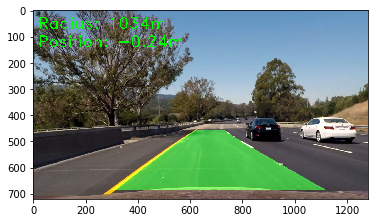

In [32]:
plt.imshow(full_pipeline(input_images[0]))
plt.show()

In [33]:
input_video = VideoFileClip("project_video.mp4")
processed_video = input_video.fl_image(full_pipeline)
processed_video.write_videofile("project_video_output.mp4", audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:46<00:00,  7.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

